In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

import re
import string
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import sys

from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.similarities import MatrixSimilarity
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from nltk import word_tokenize, WordNetLemmatizer, pos_tag
from nltk.corpus import stopwords, wordnet

from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint

% matplotlib inline

X:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# FILE PROCESSING 
def get_subtitle_fns(folder_fn_regex='srt/*'):
    return glob.glob(folder_fn_regex)

def get_subtitle_names(folder_fn_regex='srt/*'):
    filenames = glob.glob(folder_fn_regex)
    return [fn[4:-4] for fn in filenames] # remove srt\\ and .srt

In [22]:
# SUBTITLE PREPROCESSING
def get_subtitle_corpus(subtitle_fns):
    return [preprocess_movie_by_subs(s_fn) for s_fn in subtitle_fns]

def preprocess_movie_by_subs(subtitle_fn):
    return preprocess_subs(get_raw_subs(subtitle_fn))

def get_raw_subs(filename):
    # expected subtitle format:
        # numeric timestamp index
        # timestamp
        # subtitles on >= one line
        # linebreak

    # end of a subtitle line is expected to be a full word (i.e., not hyphenated)

    # subtitles may have the following qualities:
        # 1. markup (bold, italics, font colour) is between <> 
            # e.g., <font color="#00ff00"></font> 
        # 2. begin with hyphens
        # 3. contain punctuation
        # 4. begin (subtitle index 0) and end with subtitle credits of the same format 
        # 5. end with "The End"
        # 6. contain credits at the start of the subtitles 
    subs = []
    sub_chunk = []
    
    with open(filename, 'r') as f:
        for line in f:          
            # collect subtitles for each timestamped subtitle chunk
            if line != '\n': # separate chunks are newline separated
                sub_chunk.append(line[:-1]) # remove newline
                continue
            
            # skip author credits
            sub_idx = sub_chunk[0]
            is_sub_author_credits = (sub_idx == '0')
            if is_sub_author_credits: 
                sub_chunk = []
                continue
            
            subs = add_sub(subs, sub_chunk)
                
            # reset for each timestamped chunk
            sub_chunk = [] 
    
    is_last_line_a_sub = (sub_chunk != []) # .srt sometimes ends with a newline
    if is_last_line_a_sub:
        sub = add_sub(subs, sub_chunk)
    
    return subs

def add_sub(subs, sub_chunk):
    for i, sub in enumerate(sub_chunk):            
        if i > 1: # index 0 and 1 are sub index and timestamp
            subs.append(sub)
    return subs

def preprocess_subs(raw):
    # remove markup
    markup = '<[^>]*>'
    subs = [re.sub(markup, '', r) for r in raw]
    
    # tokenisation case-folding
    subs = [word_tokenize(s.lower()) for s in subs]
    
    # remove stopwords and punctuation
    stops = set(stopwords.words('english'))
    stops = stops.union(string.punctuation)
    subs = [[t for t in sub if t not in stops] for sub in subs]
    
    # lemmatize
    pos = get_pos_tags(subs) # different POS lemmatize differently
    subs = [t for sub in subs for t in sub] # flatten
    lmtzr = WordNetLemmatizer()
    subs = [lmtzr.lemmatize(s, pos[i]) for i, s in enumerate(subs)]
        
    return subs

def get_pos_tags(subs):
    pos = [pos_tag(sub) for sub in subs]
    pos = [get_wordnet_pos(tag) for sub in pos for t, tag in sub] # flatten
    return pos

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else: # default POS in WordNetLemmatizer is noun
        return wordnet.NOUN

def get_vocabulary(bag_of_words):
    return set(bag_of_words)

def run_lda(corpus, dictionary, num_topics, is_save=False):
    num_topics = num_topics # paper used 55 for their corpus
    chunksize = 2000 # online learning improves topic models (Hoffman, Blei, & Bach, 2010))
    passes = 100 # TODO adjust this
    iterations = 500 # TODO adjust this --- passes and iterations must be adjusted to convergence
    eval_every = None # apparently evaluating model perplexity takes too much time?

    # logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # to get convergence logs

    lda = LdaModel(corpus, 
                   id2word=dictionary,
                   chunksize=chunksize,
                   passes=passes,
                   iterations=iterations,
                   num_topics=num_topics,
                   random_state=0,
                   eval_every=eval_every)
    
    if is_save:
        lda.save(datapath(sys.path[1] + '\\lda')) # absolute path
    
    return lda

def load_lda(filename):
    return LdaModel.load(filename)

In [114]:
# VISUALISATIONS

def plot_average_topic_coherences(min_topics, avg_topic_coherences):    
    index = np.arange(min_topics, min_topics + len(avg_topic_coherences), 1)
    col_name = 'avg_topic_coherence'
    df = pd.DataFrame(avg_topic_coherences, index=index, columns=[col_name])

    plt.plot(df)

    plt.ylabel('Mean Topic Coherence (UMass)')
    plt.xlabel('Number of Topics')

    plt.show()
    max_df = df[df[col_name] == df[col_name].max()]
    print('max avg topic coherence:', max_df.values[0][0])
    print('optimal topics:', max_df.index.values[0])
   
def wordcloud(top_topics, filename=None):
    # based on inverse word likelihood for each topic
    word_topic_likelihood_idx = 0
    topic_coherence_idx = 1

    for i, top_topic in enumerate(top_topics):
        words = []

        for wtl, w in top_topic[word_topic_likelihood_idx]:
            frequency = int(round(1/wtl))
            words.append([w] * frequency)

        words = [w for word in words for w in word] # flatten
        words = " ".join(words) # WordCloud expects str

        wordcloud = WordCloud(max_words=30, collocations=False).generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        
        if filename != None:
            fig = plt.gcf()
            fig.savefig(filename + "_wordcloud_" + str(i) + ".pdf")
            
        plt.show() 
    
def heatmap(matrix, filename=None):
    movie_names = get_subtitle_names()
    hm = sns.heatmap(matrix, xticklabels=movie_names, yticklabels=movie_names)
    
    if filename != None:
        hm.get_figure().savefig(filename + '_heatmap.pdf')

In [5]:
# CORPUS -> BAG OF WORDS (BOW) CORPUS 
movies_corpus = get_subtitle_corpus(get_subtitle_fns()) 
dictionary = Dictionary(movies_corpus) # fit

# In the paper, low information words based on how frequently they appear in 
# the intra-document and inter-document levels were removed:
    # 1. sparsely occurring words for each document; and 
    # 2. words frequent over the WHOLE collection

# Second step: remove words appearing in <no_below or >no_above% movies
dictionary.filter_extremes(no_below=2, no_above=0.5)

movies_corpus = [dictionary.doc2bow(movie) for movie in movies_corpus] # vect

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


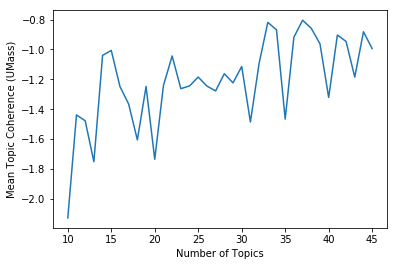

max avg topic coherence: -0.8045955880307454
optimal topics: 37
Wall time: 2min 10s


In [23]:
%%time
# USING BOW -> lDA, WHAT IS THE OPTIMAL NUMBER OF TOPICS? 

min_topic = 10
max_topic = 45

avg_topic_coherences = [0] * (max_topic - min_topic + 1)

for i in range(min_topic, max_topic+1):
    print(i)
    lda = run_lda(movies_corpus, dictionary, i)
    top_topics = lda.top_topics(movies_corpus, topn=i)
    topic_coherence_idx = 1
    avg_topic_coherence = sum([t[topic_coherence_idx] for t in top_topics]) / i
    avg_topic_coherences[i-min_topic] = avg_topic_coherence

plot_average_topic_coherences(min_topic, avg_topic_coherences)

In [121]:
# Given the optimal number of topics for the corpus, display the average topic coherence and top topics
optimal_num_topics = 37
lda = run_lda(movies_corpus, dictionary, optimal_num_topics)
top_topics = lda.top_topics(movies_corpus, topn=optimal_num_topics)
topic_coherence_idx = 1
avg_topic_coherence = sum([t[topic_coherence_idx] for t in top_topics]) / optimal_num_topics

print('Average topic coherence: %.4f' % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: -0.8052
[([(0.030451404, 'frank'),
   (0.023839302, 'colonel'),
   (0.015904784, 'american'),
   (0.015904784, 'forever'),
   (0.013259943, 'gentleman'),
   (0.010615105, 'left'),
   (0.009292683, 'chopper'),
   (0.009292683, 'weapon'),
   (0.009292683, 'grenade'),
   (0.009292683, '10'),
   (0.009292683, 'tall'),
   (0.007970262, 'bridge'),
   (0.007970262, 'prisoner'),
   (0.007970262, 'fuck'),
   (0.007970262, 'team'),
   (0.007970262, 'camp'),
   (0.006647842, 'family'),
   (0.006647842, 'asshole'),
   (0.006647842, 'behind'),
   (0.006647842, 'fly'),
   (0.006647842, 'brother'),
   (0.006647842, 'vietnam'),
   (0.0053254226, 'red'),
   (0.0053254226, 'charge'),
   (0.0053254226, 'hour'),
   (0.0053254226, 'buddy'),
   (0.0053254226, 'as'),
   (0.0053254226, 'sleep'),
   (0.0053254217, 'reach'),
   (0.004003002, 'certain'),
   (0.004003002, 'strong'),
   (0.004003002, 'picture'),
   (0.004003002, 'proof'),
   (0.004003002, 'operation'),
   (0.004003002, 'ra

In [122]:
# TOPIC SIMILARITY: cosine similarity between topic components 

def get_movie_similarity(index, subtitle_fn):    
    movie = preprocess_movie_by_subs(subtitle_fn)
    sims = index[lda[dictionary.doc2bow(movie)]]
    return sort_desc_movie_similarities(sims)

def get_movie_similarities(lda, index, movies_corpus):
    return [index[lda[movie]] for movie in movies_corpus]

def sort_desc_movie_similarities(sims):
    movie_names = get_subtitle_names()
    return sorted(zip(movie_names, sims), key=lambda sim: -sim[1])

index = MatrixSimilarity(lda[movies_corpus]) 
# if memory is an issue, use Similarity: https://radimrehurek.com/gensim/similarities/docsim.html
# "For example, a corpus of one million documents would require 2GB of RAM in a 256-dimensional LSI space, when used with this class."
# https://radimrehurek.com/gensim/tut3.html

movie_names = get_subtitle_names()
similarities = get_movie_similarities(lda, index, movies_corpus)

for movie, sims in zip(movie_names, similarities):
    print("*****", movie.upper(), "*****")
    print(sort_desc_movie_similarities(sims))
    print()

***** 48 HRS *****
[('48 Hrs', 0.99999994), ('Street of Fire', 0.2758152), ('First Blood', 0.0), ('Hard Times', 0.0), ("Howl's Moving Castle", 0.0), ('Ponyo', 0.0), ('Princess Mononoke', 0.0), ('Southern Comfort', 0.0), ('Spirited Away', 0.0), ('The Driver', 0.0), ('The Long Riders', 0.0), ('The Warriors', 0.0), ('Uncommon Valor', 0.0), ('Wake in Fright', 0.0)]

***** FIRST BLOOD *****
[('First Blood', 1.0), ('48 Hrs', 0.0), ('Hard Times', 0.0), ("Howl's Moving Castle", 0.0), ('Ponyo', 0.0), ('Princess Mononoke', 0.0), ('Southern Comfort', 0.0), ('Spirited Away', 0.0), ('Street of Fire', 0.0), ('The Driver', 0.0), ('The Long Riders', 0.0), ('The Warriors', 0.0), ('Uncommon Valor', 0.0), ('Wake in Fright', 0.0)]

***** HARD TIMES *****
[('Hard Times', 1.0), ('Street of Fire', 0.09965457), ('48 Hrs', 0.0), ('First Blood', 0.0), ("Howl's Moving Castle", 0.0), ('Ponyo', 0.0), ('Princess Mononoke', 0.0), ('Southern Comfort', 0.0), ('Spirited Away', 0.0), ('The Driver', 0.0), ('The Long Ride

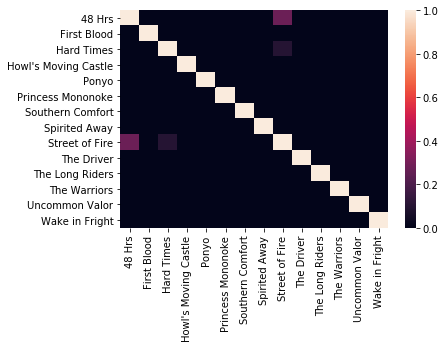

In [123]:
# VISUALISE TOTAL SIMILARITY MATRIX 
heatmap(get_movie_similarities(lda, index, movies_corpus), filename=str(optimal_num_topics))

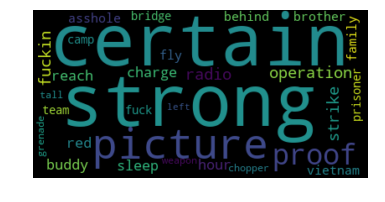

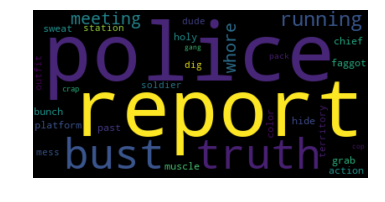

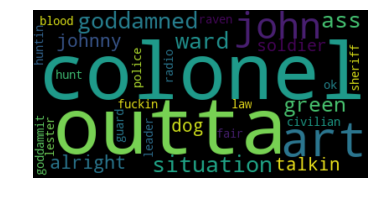

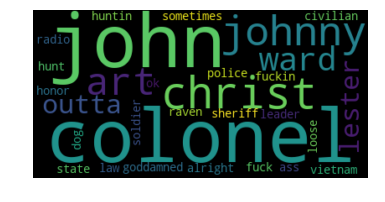

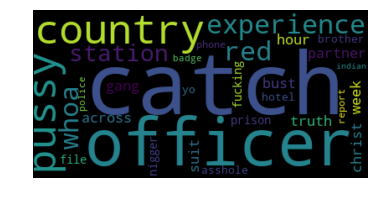

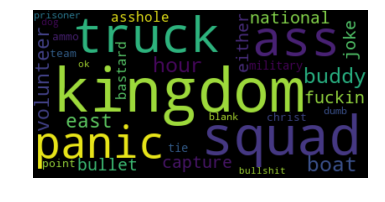

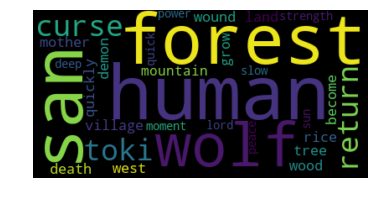

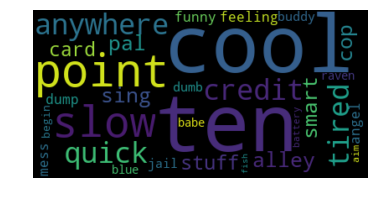

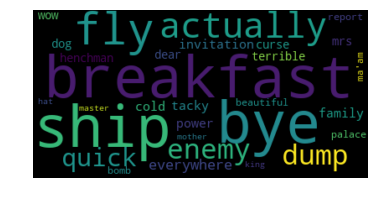

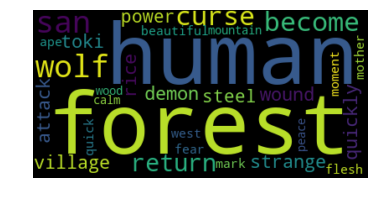

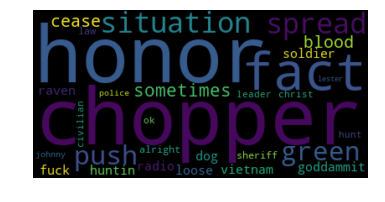

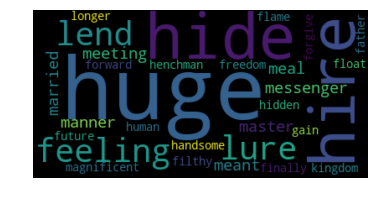

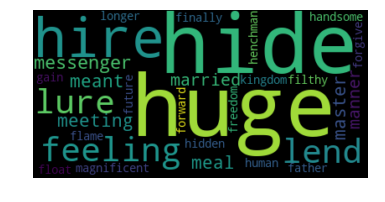

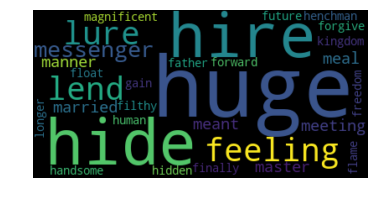

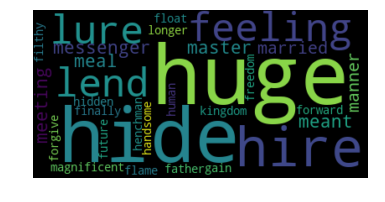

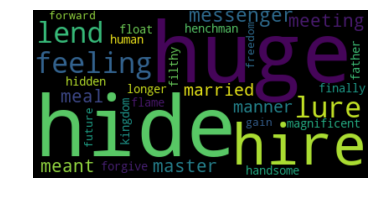

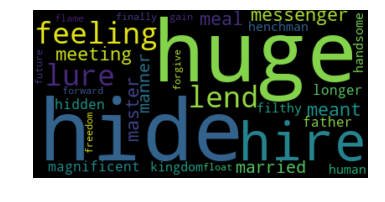

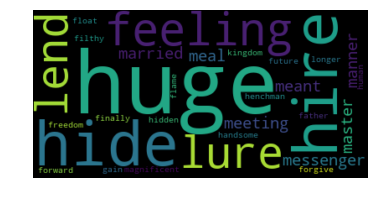

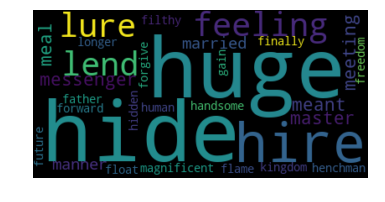

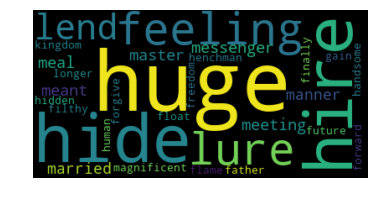

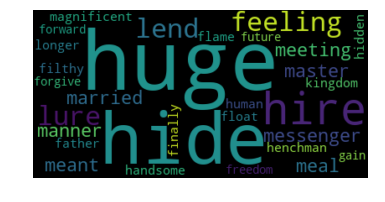

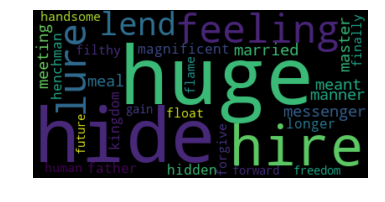

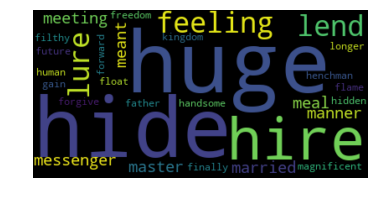

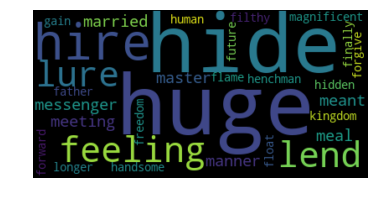

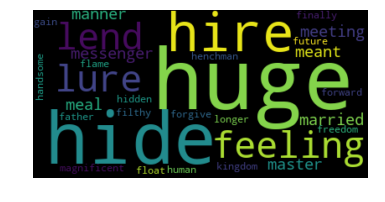

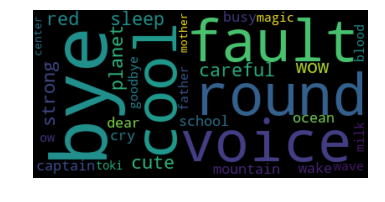

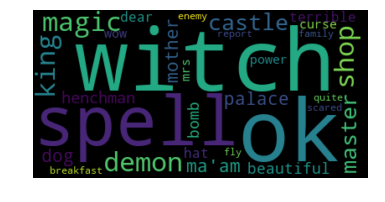

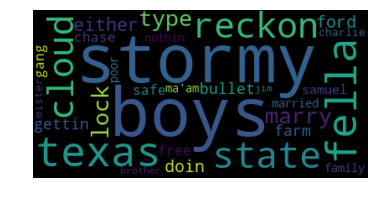

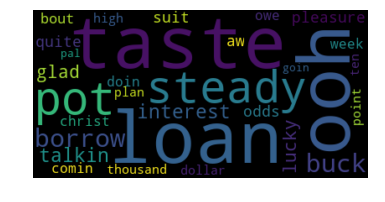

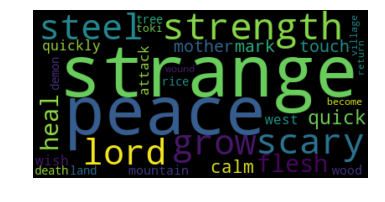

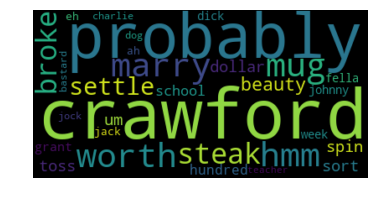

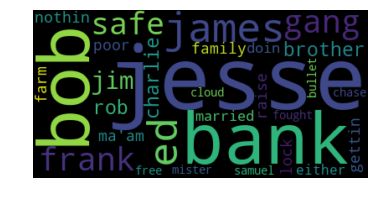

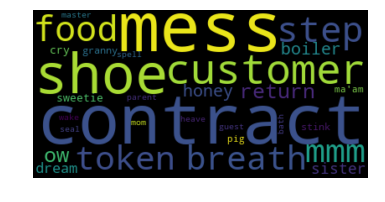

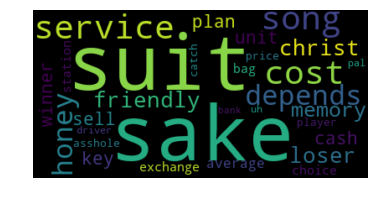

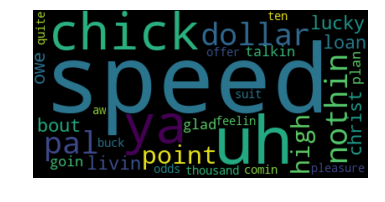

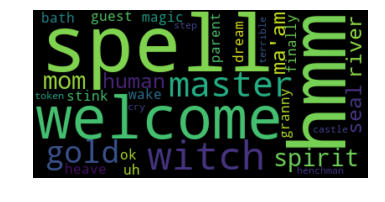

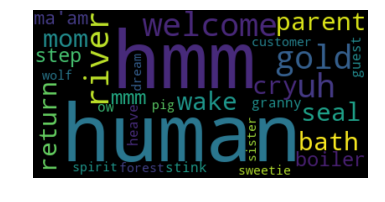

In [124]:
# VISUALISE WORD CLOUD FOR EACH TOPIC
wordcloud(top_topics, filename=str(optimal_num_topics))

In [49]:
for i, movie in enumerate(movie_names):
    print(lda[movies_corpus[i]])


[(3, 0.044691212), (7, 0.07943806), (9, 0.4212919), (16, 0.028303042), (23, 0.027096342), (27, 0.035551067), (33, 0.03336301), (34, 0.25185412), (39, 0.05223558)]
[(3, 0.42529485), (7, 0.09944438), (9, 0.07727206), (13, 0.010519014), (23, 0.019523596), (27, 0.058074255), (33, 0.026706066), (34, 0.22486201), (39, 0.03539606)]
[(3, 0.035332687), (6, 0.011551218), (7, 0.047394592), (9, 0.06650259), (13, 0.019991972), (16, 0.011876183), (23, 0.0159637), (27, 0.04899991), (29, 0.025155386), (33, 0.46313274), (34, 0.21682599), (39, 0.035991013)]
[(3, 0.029250935), (6, 0.04037883), (7, 0.044271305), (9, 0.57964754), (13, 0.029162738), (27, 0.09789203), (33, 0.012942035), (34, 0.1339027), (39, 0.019965459)]
[(3, 0.02788486), (6, 0.017388461), (7, 0.0120323645), (9, 0.07927674), (13, 0.021366565), (27, 0.72529995), (34, 0.083559364), (39, 0.014487108)]
[(3, 0.04972408), (6, 0.37439603), (7, 0.050485294), (9, 0.106881686), (13, 0.037321422), (16, 0.015142235), (23, 0.017410431), (27, 0.16262074)

In [96]:
print(top_topics[29])

([(0.0006724949, 'feeling'), (0.0006724949, 'hire'), (0.0006724949, 'hide'), (0.0006724949, 'hidden'), (0.0006724949, 'henchman'), (0.0006724949, 'harbor'), (0.0006724949, 'handsome'), (0.0006724949, 'guide'), (0.0006724949, 'grow'), (0.0006724949, 'gorgeous'), (0.0006724949, 'gift'), (0.0006724949, 'general'), (0.0006724949, 'gain'), (0.0006724949, 'future'), (0.0006724949, 'freedom'), (0.0006724949, 'forward'), (0.0006724949, 'forgive'), (0.0006724949, 'float'), (0.0006724949, 'flame'), (0.0006724949, 'finally'), (0.0006724949, 'huge'), (0.0006724949, 'filthy'), (0.0006724949, 'human'), (0.0006724949, 'impossible'), (0.0006724949, 'father'), (0.0006724949, 'messenger'), (0.0006724949, 'meeting'), (0.0006724949, 'meant'), (0.0006724949, 'meal'), (0.0006724949, 'master'), (0.0006724949, 'married'), (0.0006724949, 'manner'), (0.0006724949, 'magnificent'), (0.0006724949, 'lure'), (0.0006724949, 'longer'), (0.0006724949, 'lend'), (0.0006724949, 'lazy'), (0.0006724949, 'lake'), (0.00067249